## Estimating the Importance of Missing Articles

Our goal is estimate the importance of the set of articles that exist in English but not in Spanish Wikipedia. As a measure of importance, I use the percentile of the 

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from ConfigParser import SafeConfigParser
from operator import add
from pyspark.mllib.recommendation import ALS, Rating
import random 
from random import randint
import itertools
from math import sqrt
import numpy as np
from pprint import pprint
import math
from ConfigParser import SafeConfigParser
import pandas as pd
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from eval_util import *

from sklearn import cross_validation, grid_search
from sklearn.cross_validation import StratifiedKFold
import multiprocessing
from sklearn.linear_model import LinearRegression
from scipy.sparse import coo_matrix, hstack
import sklearn
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression


def get_parser(names):
    def loadRecord(line):
        cells = line.strip().split('\t')
        return dict(zip(names, cells))
    return loadRecord


def get_X(M, df, index_col, feature_cols):
    if M is None or index_col is None:
        l = []
    else:
        l = [M[df[index_col]], ]
    for col in feature_cols:
         l.append(coo_matrix(df[col].astype('float')).T)
    return hstack(l).toarray()


def spearman(x, y):
    sr = spearmanr(x, y)[0]
    print 'Spearman: %2.5f \n' % sr
    return sr

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print 'MSE: %2.5f' % mse
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print 'R2: %2.5f' % r2
     return r2

def multi_score(y_true,y_pred):    
    MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    R2(y_true,y_pred)
    score = spearman(y_true,y_pred)
    return score

def multi_scorer():
    return make_scorer(multi_score, greater_is_better=True) # change for false if using MSE



def cv (X, y, folds, alg, param_grid, scoring  = multi_scorer()):
    """
    Determine the best model via cross validation. This should be run on training data.
    """

    print "\n\n\nDoing Gridsearch\n"

    kfold_cv = cross_validation.KFold(X.shape[0], n_folds=folds, shuffle=True)
    model = grid_search.GridSearchCV(cv  = kfold_cv, estimator = alg, param_grid = param_grid, scoring = scoring) #n_jobs=multiprocessing.cpu_count()
    model = model.fit(X,y)
    # model trained on all data
    y_pred = model.predict(X)
    print "Best Model Train MSE: %f" % sklearn.metrics.mean_squared_error(y, y_pred)
    print "Best Model Train Spearman %f" % spearman(y, y_pred)


    print("\nBest parameters set found:")
    best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
    print(best_parameters, score)
    print "\n"
    print("Grid scores:")
    for params, mean_score, scores in model.grid_scores_:
        print("%0.5f (+/-%0.05f) for %r"
              % (mean_score, scores.std() / 2, params))

    return model

config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

['/home/ellery/wikimedia/missing_articles/missing_articles.ini']

In [2]:
s = 'en'
t = 'fr'
t_country_name = 'France'
exp_dir = '%s-%s' % (s, t)

#### Load pagview data

In [30]:
def get_ranking_score(t):
    lang_id, items = t
    items = list(items)
    item_ranks = np.argsort(np.array([x['pageview_count'] for x in items]))
    n = float(len(items))
    for r, i in enumerate(item_ranks):
        items[i]['rank'] = r/n
    return items

def make_counts_float(x):
    x['pageview_count']  = float(x['pageview_count'])  
    return x                                 
                                      
names = [ 'id', 'lang', 'title', 'pageview_count']

pageviews = sc.textFile(cp.get('general', 'pageviews'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 4)\
.filter(lambda x: ':' not in x['title'])\
.filter(lambda x: x['lang'] == s or x['lang'] == t)\
.map(make_counts_float)\
.map(lambda x: (x['lang'], x))\
.groupByKey()\
.flatMap(get_ranking_score)\
.collect()

s_or_t_views = pd.DataFrame(pageviews, columns = [ 'id', 'lang', 'title', 'pageview_count', 'rank'])
s_or_t_views.index = s_or_t_views.id
del s_or_t_views['id']
del pageviews


In [ ]:
s_or_t_views.to_csv('/home/ellery/'+exp_dir+'/s_or_t_views.tsv', encoding = 'utf8', sep = '\t')

In [ ]:
s_or_t_views = pd.read_csv('/home/ellery/'+expdir+'/s_or_t_views.tsv', encoding = 'utf8', sep = '\t')

#### Load Document Vectors

In [5]:
# Load doc vectors
lda_dir = 'en_lda'
base_dir = os.path.join(cp.get('general', 'local_data_dir'), lda_dir)
dict_file = os.path.join(base_dir, cp.get('LDA', 'article2index'))
id2index, _ , _ = get_universal_maps(dict_file)
mm_file = os.path.join(base_dir, cp.get('LDA', 'doc2topic'))
f = open(mm_file)
M = mmread(f).tocsr()

#### Merge Pageviews and Document Vectors

In [31]:
# Merge 
print 'pre merge', s_or_t_views.shape
id2index_df = pd.DataFrame(id2index.items(), columns = ['id', 'indx'])
id2index_df.index = id2index_df['id']
del id2index_df['id']
s_or_t_views = s_or_t_views.merge(id2index_df, left_index=True, right_index=True)
s_or_t_views['log_pageview_count'] = np.log(s_or_t_views['pageview_count'])
print 'post merge', s_or_t_views.shape

pre merge (6392977, 4)
post merge (5687499, 6)


#### Get Training Data
Training examples come from items that exist in en and es wiki. 

Training features include
- the LDA vector for the english article
- the percentile of the english article
- the log of the pageviews of the english article

The response is the percentile of the article in spanish

In [32]:
# Get Training Data
t_views = s_or_t_views[s_or_t_views['lang'] == t]
del t_views['lang']
del t_views['indx']
t_views.columns = ['title_t', 'pageview_count_t', 'rank_t', 'log_pageview_count_t']
s_views = s_or_t_views[s_or_t_views['lang'] == s]
del s_views['lang']
s_views.columns = ['title_s', 'pageview_count_s', 'rank_s', 'indx', 'log_pageview_count_s']
s_and_t_views = t_views.merge(s_views, left_index=True, right_index=True, copy=True)
s_and_t_views['id'] = s_and_t_views.index

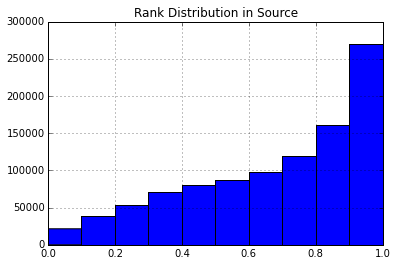

In [33]:
# Check Rank Distribution of articles that exist in the source and the target
s_and_t_views['rank_s'].hist()
plt.title('Rank Distribution in Source')

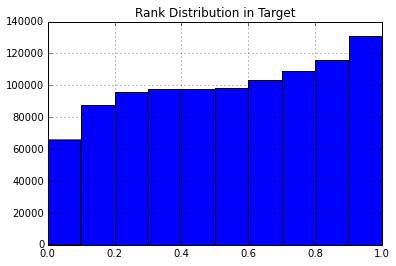

In [34]:
s_and_t_views['rank_t'].hist()
plt.title('Rank Distribution in Target')

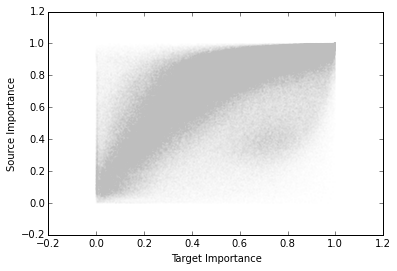

In [35]:
plt.scatter(s_and_t_views['rank_t'], s_and_t_views['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.05)
plt.xlabel('Target Importance')
plt.ylabel('Source Importance')

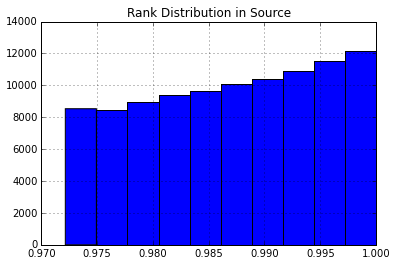

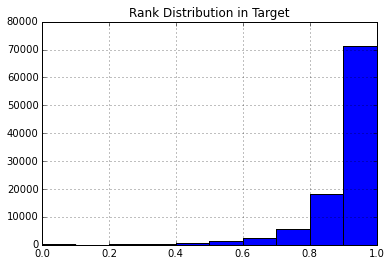

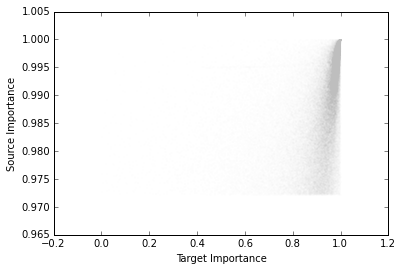

In [42]:
top_n_s = s_and_t_views.sort('rank_s', ascending = False)[:100000]
plt.figure()
top_n_s['rank_s'].hist()
plt.title('Rank Distribution in Source')
plt.figure()
top_n_s['rank_t'].hist()
plt.title('Rank Distribution in Target')
plt.figure()
plt.scatter(top_n_s['rank_t'], top_n_s['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.05)
plt.xlabel('Target Importance')
plt.ylabel('Source Importance')
#plt.ylim(0.0, 1.1)

Low S rank iif low T rank

### Getting Dump Features

In [43]:
feature_file = "/home/ellery/en-en/dump_features.tsv"
dump_df = pd.read_csv(feature_file, encoding = 'utf8', sep = '\t')
del dump_df['Unnamed: 0']
dump_df['title'] = dump_df['title'].apply(lambda x: unicode(x).replace(u' ', u'_'))
dump_df['log_length'] = dump_df['length'].apply(np.log)
print s_and_t_views.shape
s_and_t_views = s_and_t_views.merge(dump_df, how = 'inner', left_on = 'title_s', right_on = 'title' )
del s_and_t_views['title']
print s_and_t_views.shape

(1002435, 10)
(1000641, 14)


In [44]:
s_and_t_views.head()

,title_t,pageview_count_t,rank_t,log_pageview_count_t,title_s,pageview_count_s,rank_s,indx,log_pageview_count_s,id,length,is_dis,is_stub,log_length
0,Univers,104660,0.997213,11.558472,Universe,878015,0.999469,825863,13.685419,Q1,92962,False,False,11.439946
1,Boston,121015,0.997817,11.703670,Boston,1331884,0.999770,2742805,14.102105,Q100,144772,False,False,11.882915
2,Gabon,207321,0.999260,12.242024,Gabon,431256,0.998082,142978,12.974457,Q1000,45733,False,False,10.730575
3,Wikipédia_en_néerlandais,4432,0.897308,8.396606,Dutch_Wikipedia,14446,0.908522,4669008,9.578173,Q10000,7205,False,False,8.882531
4,Cadier_en_Keer,486,0.497767,6.186209,Cadier_en_Keer,1002,0.340279,3703458,6.909753,Q100000,2327,False,True,7.752335


#Get Pageviews in Local Language

In [51]:
geo_file = "/home/ellery/en_views_from_fr_es_reduced.tsv"
geo_df = pd.read_csv(geo_file, encoding = 'utf8', sep = '\t')
geo_df = geo_df[geo_df['country'] == t_country_name]
del geo_df['country']
geo_df.columns = ['title_s', 'pageview_count_from_t_to_s' ]

In [56]:
print s_and_t_views.shape
s_and_t_views = s_and_t_views.merge(geo_df, on = 'title_s', how = 'left')
print s_and_t_views.shape
s_and_t_views['pageview_count_from_t_to_s'] = s_and_t_views['pageview_count_from_t_to_s'].fillna(1)
s_and_t_views['log_pageview_count_from_t_to_s'] = np.log(s_and_t_views['pageview_count_from_t_to_s'])

(1000641, 14)
(1000648, 15)


## Subsample Data for Model Building

In [70]:
# code for sub-sampling training data
fraction = 1.0
rows = random.sample(s_and_t_views.index, int(fraction*s_and_t_views.shape[0]))
s_and_t_views_sample = s_and_t_views.ix[rows]

#### Baselines
What if we simply use the percentile of the article in english as our prediction?

In [71]:
print "Baseline MSE", sklearn.metrics.mean_squared_error(s_and_t_views_sample['rank_s'], s_and_t_views_sample['rank_t'])
print "Baseline Spearman", spearmanr(s_and_t_views_sample['rank_s'], s_and_t_views_sample['rank_t'])

Baseline MSE 0.0736118590891
Baseline Spearman (0.6727270551781509, 0.0)


In [72]:
# Just en_ranks and views
X = get_X(None, s_and_t_views_sample, None, ['rank_s', 'pageview_count_s', 'log_pageview_count_s'])
y = s_and_t_views_sample['rank_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})





Doing Gridsearch

MSE: 0.04351
R2: 0.46366
Spearman: 0.67302 

MSE: 0.04363
R2: 0.46321
Spearman: 0.67243 

MSE: 0.04415
R2: 0.45715
Spearman: 0.67092 

MSE: 0.04341
R2: 0.46572
Spearman: 0.67424 

MSE: 0.04374
R2: 0.46356
Spearman: 0.67280 

Best Model Train MSE: 0.043631
Spearman: 0.67270 

Best Model Train Spearman 0.672705

Best parameters set found:
({}, 0.67268415616595556)


Grid scores:
0.67268 (+/-0.00053) for {}


In [73]:
# adding pageview info from local language
features = ['rank_s', 'pageview_count_s', 'log_pageview_count_s', 'pageview_count_from_t_to_s', 'log_pageview_count_from_t_to_s' ]
X = get_X(None, s_and_t_views_sample, None, features)
y = s_and_t_views_sample['rank_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})




Doing Gridsearch

MSE: 0.03835
R2: 0.52803
Spearman: 0.72940 

MSE: 0.03864
R2: 0.52456
Spearman: 0.72741 

MSE: 0.03839
R2: 0.52780
Spearman: 0.72986 

MSE: 0.03858
R2: 0.52472
Spearman: 0.72806 

MSE: 0.03846
R2: 0.52814
Spearman: 0.72998 

Best Model Train MSE: 0.038470
Spearman: 0.72894 

Best Model Train Spearman 0.728944

Best parameters set found:
({}, 0.72894160221638415)


Grid scores:
0.72894 (+/-0.00051) for {}


In [74]:
# adding article dump features
features = ['rank_s', 'pageview_count_s', 'log_pageview_count_s', 'pageview_count_from_t_to_s', 'log_pageview_count_from_t_to_s', 'length', 'log_length', 'is_stub' ]
X = get_X(None, s_and_t_views_sample, None, features)
y = s_and_t_views_sample['rank_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})




Doing Gridsearch

MSE: 0.03805
R2: 0.53290
Spearman: 0.73234 

MSE: 0.03810
R2: 0.53285
Spearman: 0.73168 

MSE: 0.03790
R2: 0.53168
Spearman: 0.73064 

MSE: 0.03795
R2: 0.53332
Spearman: 0.73189 

MSE: 0.03787
R2: 0.53377
Spearman: 0.73218 

Best Model Train MSE: 0.037964
Spearman: 0.73177 

Best Model Train Spearman 0.731770

Best parameters set found:
({}, 0.73174678524429038)


Grid scores:
0.73175 (+/-0.00030) for {}


In [75]:
# adding all features
features = ['rank_s', 'pageview_count_s', 'log_pageview_count_s', 'pageview_count_from_t_to_s', 'log_pageview_count_from_t_to_s', 'length', 'log_length', 'is_stub' ]
X = get_X(M, s_and_t_views_sample, 'indx', features)
y = s_and_t_views_sample['rank_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})




Doing Gridsearch

MSE: 0.02484
R2: 0.69460
Spearman: 0.83970 

MSE: 0.02480
R2: 0.69514
Spearman: 0.83967 

MSE: 0.02482
R2: 0.69557
Spearman: 0.84020 

MSE: 0.02462
R2: 0.69709
Spearman: 0.84061 

MSE: 0.02471
R2: 0.69504
Spearman: 0.83948 

Best Model Train MSE: 0.024717
Spearman: 0.84012 

Best Model Train Spearman 0.840117

Best parameters set found:
({}, 0.83993119827012175)


Grid scores:
0.83993 (+/-0.00021) for {}


In [101]:
X_missing = get_X(M, s_and_t_views_sample, 'indx', features)
predicted_t_rank = model.predict(X_missing)

In [103]:
s_and_t_views_sample['predicted_rank_t'] = predicted_t_rank
s_and_t_views_sample['predicted_rank_t'] = s_and_t_views_sample['predicted_rank_t'].apply(lambda x: min(1, max(0, x)))

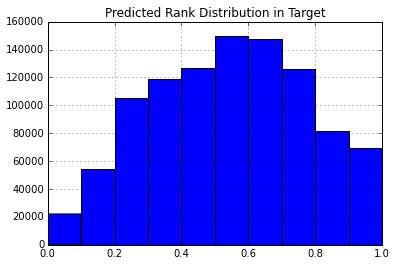

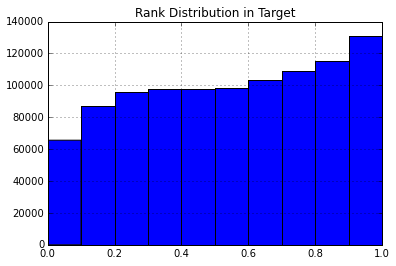

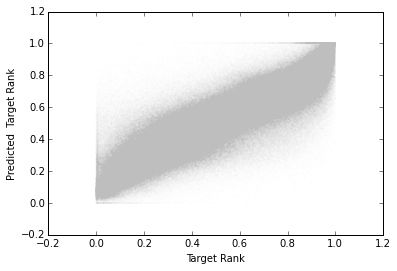

In [107]:
plt.figure()
s_and_t_views_sample['predicted_rank_t'].hist()
plt.title('Predicted Rank Distribution in Target')
plt.figure()
s_and_t_views_sample['rank_t'].hist()
plt.title('Rank Distribution in Target')
plt.figure()
plt.scatter(s_and_t_views_sample['rank_t'], s_and_t_views_sample['predicted_rank_t'], s=1, facecolor='0.5', lw = 0, alpha = 0.05)
plt.xlabel('Target Rank')
plt.ylabel('Predicted  Target Rank')
#plt.ylim(0.0, 1.1)

In [105]:
print "Final MSE", sklearn.metrics.mean_squared_error(s_and_t_views_sample['predicted_rank_t'], s_and_t_views_sample['rank_t'])
print "Final Spearman", spearmanr(s_and_t_views_sample['predicted_rank_t'], s_and_t_views_sample['rank_t'])

Final MSE 0.0244248595922
Final Spearman (0.8401128668938086, 0.0)


#### Loading the missing articles

In [129]:
topk = 500000
missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), exp_dir, cp.get('missing', 'missing_items'))
d_missing = pd.read_csv(missing_articles_file, sep='\t', names = ['id', 'title_s', 'pageview_count_s'], encoding = 'utf8')
d_missing = d_missing.sort('pageview_count_s', ascending = False)[:topk]
d_missing.index = d_missing['id']
d_missing['log_pageview_count_s'] = np.log(d_missing['pageview_count_s'])
d_missing = d_missing.merge(s_views[['indx', 'rank_s']],left_index=True, right_index=True)

In [130]:
d_missing['title_s'] = d_missing['title_s'].apply(lambda x: unicode(x).replace(u' ', u'_'))
d_missing.shape

(494414, 6)

In [131]:
d_missing = d_missing.merge(dump_df, how= 'inner', left_on = 'title_s', right_on = 'title')
del d_missing['title']
d_missing.index = d_missing['id']

In [132]:
d_missing.shape

(494206, 10)

In [133]:
d_missing = d_missing.merge(geo_df, on = 'title_s', how = 'left')
print d_missing.shape
d_missing.index = d_missing['id']
d_missing['pageview_count_from_t_to_s'] = d_missing['pageview_count_from_t_to_s'].fillna(1)
d_missing['log_pageview_count_from_t_to_s'] = np.log(d_missing['pageview_count_from_t_to_s'])

(494212, 11)


In [134]:
d_missing.head()

,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length,pageview_count_from_t_to_s,log_pageview_count_from_t_to_s
id,,,,,,,,,,,,
Q1000004,Q1000004,New_Hampshire_Route_16,8139,9.004423,263308,0.855868,22777,False,False,10.033507,16,2.772589
Q1000032,Q1000032,Unschooling,79820,11.287529,3169809,0.981618,27874,False,False,10.235450,311,5.739793
Q1000049,Q1000049,Xiasi_Dog,5421,8.598036,2768856,0.803915,3296,False,False,8.100465,10,2.302585
Q1000090,Q1000090,Lions_(album),15383,9.641018,1680919,0.913092,39791,False,False,10.591396,94,4.543295
Q1000116,Q1000116,Axiom_of_countable_choice,8765,9.078522,1176164,0.863884,5978,False,False,8.695841,76,4.330733


In [135]:
# Sanity Check Did not train in missing articles
d_missing.merge(s_and_t_views_sample,left_index=True, right_on='id').shape

(0, 30)

#### Apply our model to the mssing articles

In [136]:
X_missing = get_X(M, d_missing, 'indx', features)
rank_t = model.predict(X_missing)
d_missing['rank_t'] = rank_t

In [137]:
d_missing = d_missing.sort('rank_t', ascending = False)
d_missing.head(10)

,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length,pageview_count_from_t_to_s,log_pageview_count_from_t_to_s,rank_t
id,,,,,,,,,,,,,
Q6772702,Q6772702,Marquis_de_Sade_bibliography,19556,9.881037,2129914,0.928854,8550,False,False,9.053687,394,5.976351,1.477338
Q4950137,Q4950137,Gisela_of_France,61155,11.021167,4406124,0.975405,2220,False,False,7.705262,1623,7.392032,1.290875
Q377016,Q377016,Roland_Garros,39942,10.595184,3346490,0.962453,475,True,False,6.163315,3045,8.021256,1.289091
Q3186692,Q3186692,Calendar_year,140200,11.850825,2619048,0.990470,2345,False,False,7.760041,399,5.988961,1.273604
Q3853305,Q3853305,Maîtresse-en-titre,37615,10.535158,3652419,0.960297,5229,False,False,8.561975,244,5.497168,1.255266
Q1056289,Q1056289,École_des_Beaux-Arts,59745,10.997841,4654693,0.974795,11312,False,False,9.333619,662,6.495266,1.244319
Q343334,Q343334,Yves_Saint_Laurent,29976,10.308152,561868,0.951036,419,True,False,6.037871,267,5.587249,1.239602
Q1758677,Q1758677,Oeuvre,21275,9.965288,3965223,0.933863,1159,False,False,7.055313,51,3.931826,1.234935
Q17068610,Q17068610,Landmarks_in_Paris,15277,9.634104,3484660,0.912609,35160,False,False,10.467664,379,5.937536,1.215372


In [22]:
del d_missing['id']

In [23]:
ranked_missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), exp_dir, cp.get('missing', 'ranked_missing_items'))
d_missing.to_csv(ranked_missing_articles_file, sep='\t', encoding='utf-8')

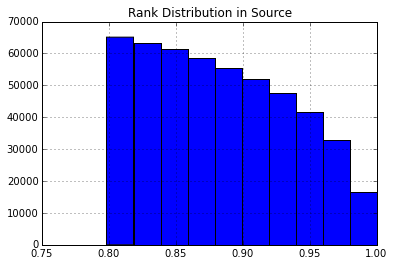

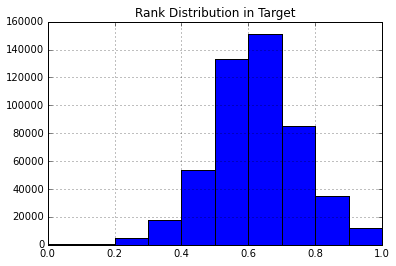

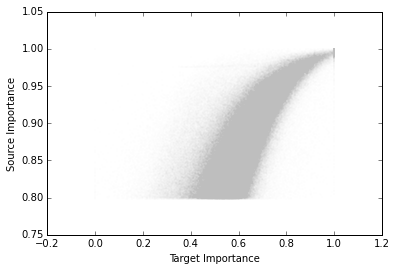

In [139]:
d_missing['rank_t'] = d_missing['rank_t'].apply(lambda x: min(1, max(0, x)))
plt.figure()
d_missing['rank_s'].hist()
plt.title('Rank Distribution in Source')
plt.figure()
d_missing['rank_t'].hist()
plt.title('Rank Distribution in Target')
plt.figure()
plt.scatter(d_missing['rank_t'], d_missing['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.05)
plt.xlabel('Target Importance')
plt.ylabel('Source Importance')

#Scratch

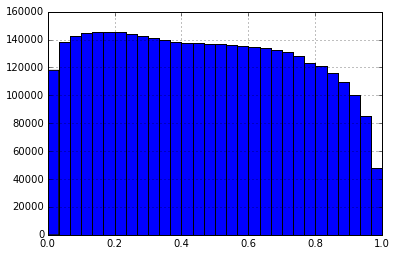

In [24]:
d_missing['rank_s'].hist(bins=30)

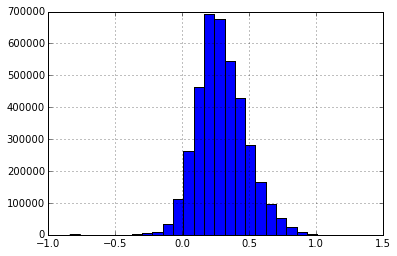

In [25]:
d_missing['rank_t'].hist(bins=30)

In [125]:

# compute spearman correlation between en as es ranks on missing articles
print "Baseline Spearman", spearmanr(d_missing_k['rank_en'], d_missing_k['rank_es'])

Baseline Spearman (0.76148637933899221, 0.0)


In [126]:
from sklearn.linear_model import Lasso
alg = Lasso()
param_grid = {'alpha': [0.000001, 0.0001, 0.001, 1]}
model = cv (X, y, 2, alg, param_grid)




Doing Gridsearch

MSE: 0.02139
R2: 0.73260
Spearman: 0.86140 

MSE: 0.02148
R2: 0.73211
Spearman: 0.86140 

MSE: 0.02309
R2: 0.71128
Spearman: 0.84927 

MSE: 0.02319
R2: 0.71080
Spearman: 0.84913 

MSE: 0.02639
R2: 0.66998
Spearman: 0.82518 

MSE: 0.02649
R2: 0.66964
Spearman: 0.82518 

MSE: 0.07998
R2: -0.00001
Spearman: nan 

MSE: 0.08019
R2: -0.00001
Spearman: nan 

Best Model Train MSE: 0.021394
Spearman: 0.86169 

Best Model Train Spearman 0.861693

Best parameters set found:
({'alpha': 1e-06}, 0.86140266086482908)


Grid scores:
0.86140 (+/-0.00000) for {'alpha': 1e-06}
0.84920 (+/-0.00003) for {'alpha': 0.0001}
0.82518 (+/-0.00000) for {'alpha': 0.001}
nan (+/-nan) for {'alpha': 1}


In [62]:
model.best_estimator_

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)

In [54]:
from sklearn.ensemble import RandomForestRegressor
alg = RandomForestRegressor()
param_grid = {'n_jobs' : [8], 'n_estimators' : [50, 500 ], 'max_depth' : [2, 3, 4 ] }
cv (X, y, 2, alg, param_grid)




Doing Gridsearch

Best Model Train MSE: 0.024215

Best parameters set found:
({'n_estimators': 50, 'n_jobs': 8, 'max_depth': 4}, -0.024152132858999739)


Grid scores:
-0.03364 (+/-0.00021) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 2}
-0.03378 (+/-0.00018) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 2}
-0.02695 (+/-0.00007) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 3}
-0.02700 (+/-0.00005) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 3}
-0.02415 (+/-0.00003) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 4}
-0.02424 (+/-0.00008) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 4}


GridSearchCV(cv=sklearn.cross_validation.KFold(n=70617, n_folds=2, shuffle=True, random_state=None),
       estimator=RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [50, 500], 'n_jobs': [8], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [57]:
from sklearn.linear_model import LinearRegression
alg = Lasso()
param_grid = {}
model = cv (rank_en.toarray(), y, 2, alg, param_grid)





Doing Gridsearch

Best Model Train MSE: 0.080153

Best parameters set found:
({}, -0.080153485281797415)


Grid scores:
-0.08015 (+/-0.00002) for {}


In [59]:
from sklearn.linear_model import LinearRegression
alg = Lasso()
param_grid = {}
model = cv (M_r.toarray(), y, 2, alg, param_grid)





Doing Gridsearch

Best Model Train MSE: 0.080153

Best parameters set found:
({}, -0.080153429784761906)


Grid scores:
-0.08015 (+/-0.00011) for {}
